In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

### Importing data

In [ ]:
sales = pd.read_csv('../data/sales_train_v2.csv')

item_cat = pd.read_csv('../data/item_categories.csv')
sub = pd.read_csv("../data/sample_submission.csv")
shops = pd.read_csv("../data/shops.csv")
item = pd.read_csv("../data/items.csv")
test = pd.read_csv("../data/test.csv")

### Converting date column to datetime

In [5]:
sales.date = sales.date.apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))

sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


### Aggregating data per month, with:

- min and max on the date
- average of the item_price
- sum of the sales

In [6]:
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

In [7]:
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

### Analysing item category data

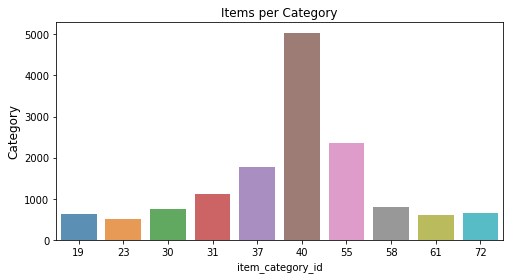

In [8]:
import seaborn as sns

x = item.groupby(['item_category_id']).count()
x = x.sort_values(by = 'item_id', ascending=False)
x = x.iloc[0:10].reset_index()

plt.figure(figsize=(8, 4))
ax = sns.barplot(x.item_category_id, x.item_id, alpha = 0.8)
plt.title('Items per Category')
plt.ylabel('# of items', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.show()

### Computing total sales per month as time series

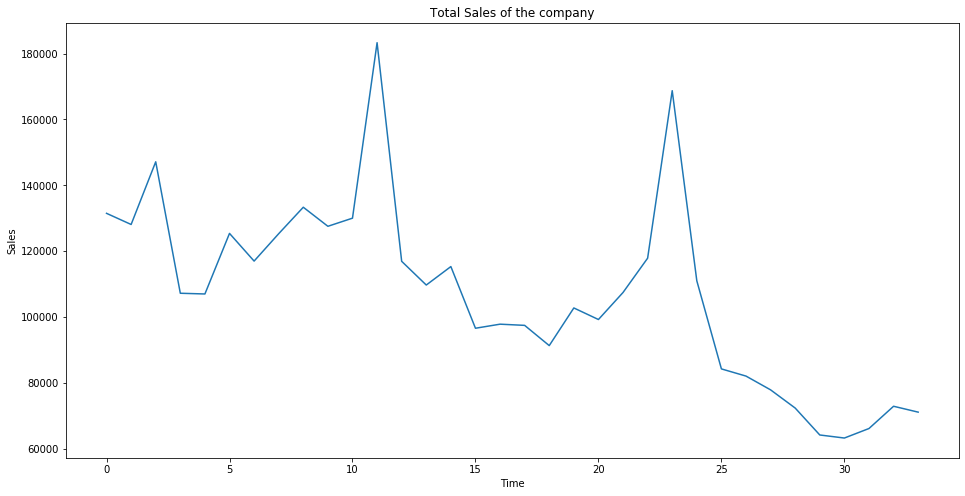

In [9]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

As expected, the last months of the year represent the period with the highest number of sales, in other words, the seasonality of the number of sales recur reasonably every year around the same time.